**Group Members:** Jojo Hu (47939335), (TODO: add your names)

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

## Background Information
A UBC Computer Science research group, led by Frank Wood, is studying how people play Minecraft by collecting player activity data from a specific server. To run the project effectively, they need to recruit the right players and manage various software and hardware resources. They want to know "kinds" of players are most likely to contribute a large amount of data so that they can target those players in their recruiting efforts.

## Research Question
We want to know: can we predict total playtime based on player age and newsletter subscription status? We will investigate this research question using KNN regression on the `players.csv` dataset

## Dataset
First, we load the data, taking care to convert the `experience` and `gender` columns to factors.

In [2]:
players <- read_csv("https://raw.githubusercontent.com/Yh194/ubc-dsci100-21/refs/heads/main/data/players.csv") |>
    mutate(across(c(experience, gender), as.factor))
# order experience levels
players$experience <- factor(players$experience, levels = c('Beginner', 'Amateur', 'Regular', 'Pro', 'Veteran'))

# list possible values for factors and their distribution
table(players$gender)
table(players$experience)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



          Agender            Female              Male        Non-binary 
                2                37               124                15 
            Other Prefer not to say      Two-Spirited 
                1                11                 6 


Beginner  Amateur  Regular      Pro  Veteran 
      35       63       36       14       48 

The `players.csv` file is a comma-separated CSV file with 7 columns and 196 rows.

### Specification

| Column Name      | Data Type | Meaning                                                   | Possible values/constraints                        |
|------------------|-----------|-----------------------------------------------------------|----------------------------------------------------|
| **experience**   | `fct`     | How much experience the player has in the game            | 'Beginner', 'Amateur', 'Regular', 'Pro', 'Veteran' |
| **subscribe**    | `lgl`     | Whether or not the player is subscribed to the newsletter |                                                    |
| **hashedEmail**  | `chr`     | The hash of the player's email, serving as a unique ID    |                                                    |
| **played_hours** | `dbl`     | The number of hours the player has played for             | Non-negative                                       |
| **name**         | `chr`     | The player's name                                         |                                                    |
| **gender**       | `fct`     | The player's gender                                       | 'Male', 'Female', 'Non-binary', 'Prefer not to say', 'Agender', 'Two-Spirited', 'Other' |
| **Age**          | `dbl`     | The player's age                                          | Non-negative                                       |

### Irrelevant Variables
`name` and `hashedEmail` are unique for each player, so they are not useful in our analysis.

### Potential Issues
- Played hours may be inaccurate because players might stay idle/AFK within the game, which would lead to an artificially inflated playtime
- Some players have disproportionately high playtime compared to others, which could skew averages
- Players could lie about or omit information such as age, gender, etc.
- There are a lot more male players (124) compared to other genders, which could introduce bias
- There are `NA` values present in the age column
- Skill level/experience is a very subjective column
  - Different people may have different opinions about what level of skill constitutes a "Pro" for example
  - The ranking is ambiguous, you can guess which value is more skilled than another but it's not clearly defined

# Methods and Results

The data is already cleaned and wrangled, so we can move on to (TODO)

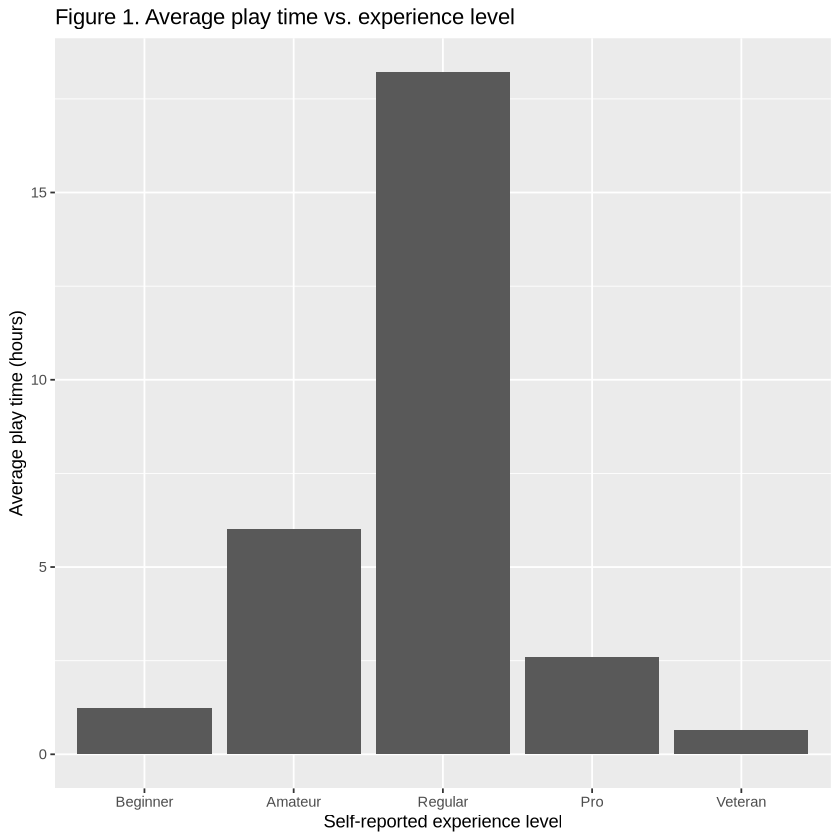

In [18]:
players_avg <- players |>
    group_by(experience) |>
    summarize(avg_played_hours = mean(played_hours))

ggplot(players_avg, aes(x = experience, y = avg_played_hours)) +
    geom_bar(stat = "identity") +
    xlab("Self-reported experience level") +
    ylab("Average play time (hours)") +
    ggtitle("Figure 1. Average play time vs. experience level")

In [10]:
spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

exp_recipe <- recipe(played_hours ~ experience + subscribe, players) |>
    step_bin2factor(subscribe) |>
    step_dummy(subscribe) |>
    step_dummy(experience, one_hot = TRUE) |>
    step_normalize(all_predictors())

# tmp
exp_recipe |> prep() |> bake(players) |> head()

played_hours,subscribe_no,experience_Beginner,experience_Amateur,experience_Regular,experience_Pro,experience_Veteran
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.3,-0.5993903,-0.4650615,-0.6864892,-0.47313,3.5963417,-0.5680401
3.8,-0.5993903,-0.4650615,-0.6864892,-0.47313,-0.2766417,1.7514571
0.0,1.6598500,-0.4650615,-0.6864892,-0.47313,-0.2766417,1.7514571
0.7,-0.5993903,-0.4650615,1.4492550,-0.47313,-0.2766417,-0.5680401
0.1,-0.5993903,-0.4650615,-0.6864892,2.10280,-0.2766417,-0.5680401
0.0,-0.5993903,-0.4650615,1.4492550,-0.47313,-0.2766417,-0.5680401


# Discussion

TODO

# References

TODO (Do we need this section?)